In [1]:
# Pearson correlation coefficient
# import glob
import os
# import datetime as dt
import numpy as np
import pandas as pd
# from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from treeinterpreter import treeinterpreter as ti
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
# from sklearn.metrics import accuracy_score, precision_recall_curve, precision_score

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import RepeatedKFold

from sklearn import svm
from sklearn.svm import SVR 

In [2]:
# Read data from csv files
df_read = pd.read_csv(f'{os.getcwd()}/market_prediction/hour_df.csv')
df_read.rename(columns={'close':'Price'}, inplace=True)

In [3]:
print(len(df_read))
df_read.set_index('date', inplace=True)
print(df_read.head())


104
                  positive  negative   neutral       score     Price
date                                                                
2022-02-27 11:00  0.136658  0.020665  0.842666  534.449361  39506.94
2022-02-27 12:00  0.140839  0.022763  0.836392  695.736467  39772.65
2022-02-27 13:00  0.154944  0.027658  0.817392  456.427667  39087.32
2022-02-27 14:00  0.137984  0.033730  0.828276  547.796955  38805.72
2022-02-27 15:00  0.137928  0.049283  0.812779  525.495285  39375.33


In [10]:
# Predicting stock prices using Random Forest Regression model
def RandomForestModel(df):
    # Split data into training and testing sets
    train_start_index = 0
    train_end_index = int(len(df) * 0.6)
    test_start_index = train_end_index + 1
    test_end_index = len(df)

    train = df.iloc[train_start_index:train_end_index]
    test = df.iloc[test_start_index:test_end_index]

    # train, test = train_test_split(df, shuffle=False, test_size=0.2)
    # print(train.size)
    # print(test.size)

    sentiment_score_list_train = []
    for date, row in train.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'score']])
        sentiment_score_list_train.append(sentiment_score)
    numpy_df_train = np.asarray(sentiment_score_list_train)

    sentiment_score_list_test = []
    for date, row in test.T.iteritems():
        sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'positive']])
        # sentiment_score = np.asarray([df.loc[date, 'score']])
        sentiment_score_list_test.append(sentiment_score)
    numpy_df_test = np.asarray(sentiment_score_list_test)

    y_train = pd.DataFrame(train['Price'])
    y_test = pd.DataFrame(test['Price'])

    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(numpy_df_train, y_train)
    prediction, bias, contributions = ti.predict(rf, numpy_df_test)

    # View accuracy of model on test data
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, prediction), 2))
    print('Mean Squared Error:', round(mean_squared_error(y_test, prediction), 2))
    print('RMSE (Root Mean Squared Error):', sqrt(mean_squared_error(y_test, prediction)))
    

    # Save the index for prediction_df as the index in the dataframe
    prediction_df = pd.DataFrame(prediction, index=test.index)

    # Plot the prediction and actual values in the same graph 
    ax = prediction_df.rename(columns={0: 'Predicted Price'}).plot(figsize=(15, 5), title='Random Forest Predicted Price', style='orange')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Stock Price Predicted')
    fig = y_test.rename(columns={'Price': 'Actual Price'}).plot(ax=ax, figsize=(15, 5), secondary_y=True, style='b-')
    fig.set_xlabel('Date and Time')
    fig.set_ylabel('Stock Price')
    plt.gcf().autofmt_xdate()
    plt.show()

    
    return prediction #, bias, contributions


C:\Users\paulc\AppData\Local\Temp/ipykernel_22500/162038877.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(numpy_df_train, y_train)


Mean Absolute Error: 2158.67
Mean Squared Error: 6344476.92
RMSE (Root Mean Squared Error): 2518.824511125103


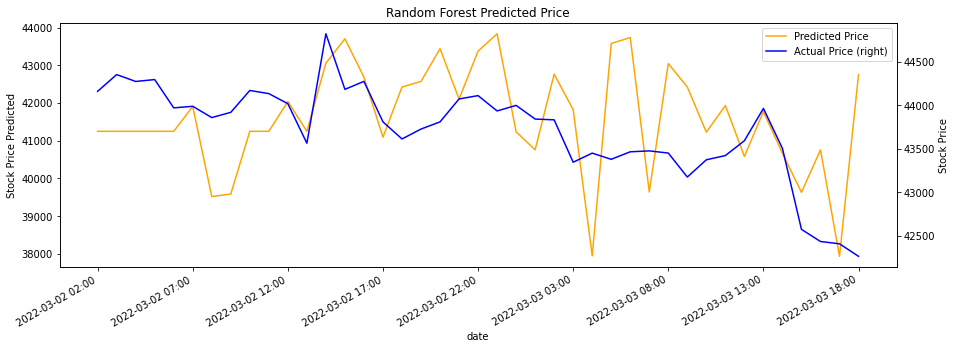

In [11]:
prediction = RandomForestModel(df_read)

In [132]:
# Evaluate the model using 10-fold cross validation by calling the function above and passing the training data  and test data
# def cross_validation(df):
#     # Split train and test data into 10 folds
#     kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=None)

#     for train_index, test_index in kf.split(df):
#         train_data = df.iloc[train_index]
#         test_data = df.iloc[test_index]

#         # Print the percentage of test data in each fold
#         print("\n\n")
#         print(f"Percentage of test data in each fold:{test_data.shape[0] / df.shape[0] * 100} %")
        
#         # Predict stock prices using Random Forest Regression model
#         prediction = RandomForestModel(train_data, test_data, df)

# cross_validation(df_read)




Percentage of positive sentiment: 16.532415132993926
Percentage of negative sentiment: 2.807411455640808
Percentage of neutral sentiment: 80.66017341136526


[]

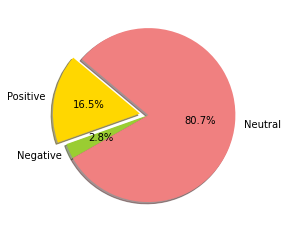

In [310]:
# Create a pie chart to show the percentage of positive and negative sentiment
positive_sentiment = df_read['positive'].sum()
negative_sentiment = df_read['negative'].sum()
neutral_sentiment = df_read['neutral'].sum()

# Percentage of positive sentiment
positive_sentiment_percentage = positive_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100
negative_sentiment_percentage = negative_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100
neutral_sentiment_percentage = neutral_sentiment / (positive_sentiment + negative_sentiment + neutral_sentiment) * 100

# Print the percentage of positive and negative sentiment
print("\n\n")
print("Percentage of positive sentiment:", positive_sentiment_percentage)
print("Percentage of negative sentiment:", negative_sentiment_percentage)
print("Percentage of neutral sentiment:", neutral_sentiment_percentage)

# Plot the pie chart 
labels = 'Positive', 'Negative', 'Neutral'
sizes = [positive_sentiment_percentage, negative_sentiment_percentage, neutral_sentiment_percentage]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.plot()

### SVM prediction

In [22]:
# Predicting stock prices using Support Vector Regression model
def SVRModel(df):
  # Split data into training and testing sets
  train_start_index = 0
  train_end_index = int(len(df) * 0.7)
  test_start_index = train_end_index + 1
  test_end_index = len(df)

  train = df.iloc[train_start_index:train_end_index]
  test = df.iloc[test_start_index:test_end_index]

  # df = pd.read_csv('sentimentAnalysis_' + stockname +'.csv')
  # train, test = train_test_split(df, shuffle=False, test_size=0.2)
  print(train.size)
  print(test.size)

  sentiment_score_list_train = []
  for date, row in train.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
    sentiment_score_list_train.append(sentiment_score)
  numpy_df_train = np.asarray(sentiment_score_list_train)

  sentiment_score_list_test = []
  for date, row in test.T.iteritems():
    sentiment_score = np.asarray([df.loc[date, 'negative'], df.loc[date, 'neutral'],  df.loc[date, 'positive']])
    sentiment_score_list_test.append(sentiment_score)
  numpy_df_test = np.asarray(sentiment_score_list_test)

  y_train = pd.DataFrame(train['Price'])
  y_test = pd.DataFrame(test['Price'])

  svr_rbf = SVR(kernel='rbf', C=1e6, gamma=0.1)
  svr_rbf.fit(numpy_df_train, y_train.values.flatten())
  output_test_svm = svr_rbf.predict(numpy_df_test)


  # Save the index for prediction_df as the index in the dataframe
  prediction_df = pd.DataFrame(output_test_svm, index=test.index)

  # Plot the prediction and actual values in the same graph 
  ax = prediction_df.rename(columns={0: 'Predicted Price'}).plot(figsize=(15, 5), title='SVM Predicted Price', style='orange')
  ax.set_xlabel('Date and Time')
  ax.set_ylabel('Stock Price Predicted')
  fig = y_test.rename(columns={'Price': 'Actual Price'}).plot(ax=ax, figsize=(15, 5), secondary_y=True, style='b-')
  fig.set_xlabel('Date and Time')
  fig.set_ylabel('Stock Price')
  plt.gcf().autofmt_xdate()
  plt.show()

  # Calculate the RMSE and MAE
  rmse = sqrt(mean_squared_error(y_test, output_test_svm))
  mae = mean_absolute_error(y_test, output_test_svm)

  # Print the RMSE and MAE
  print("\n\n")
  print("RMSE:", rmse)
  print("MAE:", mae)
  

  # plt.figure()
  # plt.plot(test['Price'].iloc[:].values)
  # plt.plot(output_test_svm)
  # plt.title('SVM predicted prices')
  # plt.ylabel('Stock Prices')
  # plt.xlabel('Days')
  # plt.legend(['actual', 'predicted'])
  # plt.show()

  # print("\n\n")
  # print("RMSE value for Support Vector Regression Model : ")
  # rmse = sqrt(mean_squared_error(y_test, output_test_svm))
  # print(rmse)
  # print("\n\n")

360
155


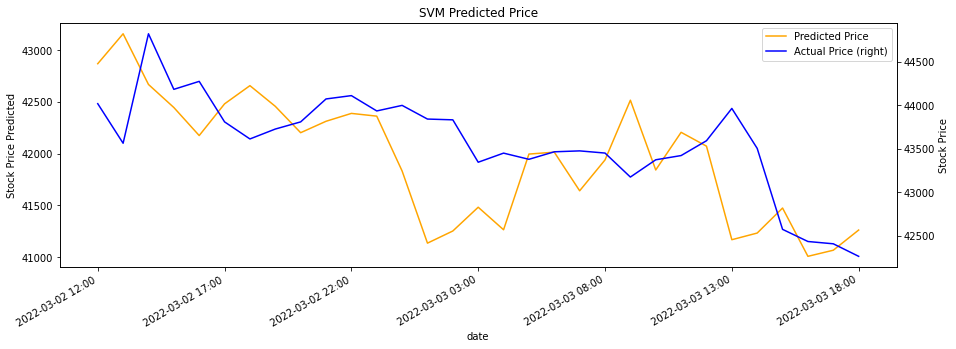




RMSE: 1715.753407207911
MAE: 1623.917222309089


In [23]:
SVRModel(df_read)

### LSTM approach - 
## Correlation coefficient between the price and the sentiment (but the sentiment should not be between 0 and 1).

## 

In [2]:
# Read BTC_price_history.csv file
import pandas as pd
df_btc = pd.read_csv('BTC_price_history.csv')

df_hour = pd.read_csv('hour_df_merged.csv')

In [6]:
# sort df_hour and print first and last elemtne
df_hour.sort_values(by=['date'], inplace=True)

# print first and last date in df_hour
print("\n\n")
print("First date in df_hour:", df_hour.iloc[0]['date'])
print("Last date in df_hour:", df_hour.iloc[-1]['date'])

print(len(df_hour))




First date in df_hour: 2022-02-27 11:00
Last date in df_hour: 2022-03-07 00:00
189


In [15]:
# print first and last date in df_btc
print("\n\n")
print("First date in df_btc:", df_btc.iloc[0]['time'])
print("Last date in df_btc:", df_btc.iloc[-1]['time'])




First date in df_btc: 2022-03-08 10:00:00
Last date in df_btc: 2022-01-07 10:00:00


In [8]:
# create a dataframe to store df_btc between the first and last date in df_hour
df_btc_hour =

In [12]:
print(len(df_btc_hour))
print(df_btc_hour.head())

181
    Unnamed: 0                 time     close
35        1405  2022-03-06 23:00:00  38428.92
36        1404  2022-03-06 22:00:00  38972.92
37        1403  2022-03-06 21:00:00  39010.04
38        1402  2022-03-06 20:00:00  38860.96
39        1401  2022-03-06 19:00:00  38693.26


In [10]:
# find which lines are missing in dataframe between df_btc_hour and df_hour
missing_lines = df_hour[~df_hour['date'].isin(df_btc_hour['time'])]

In [11]:
print("\n\n")
print("Number of missing lines:", len(missing_lines))




Number of missing lines: 189


In [20]:
# Read from market_prediction folder all files with format hour_df_*.csv
import glob
import pandas as pd

count = 0
df_concat = pd.DataFrame()
for file in glob.glob("market_prediction/hour_df_*.csv"):
    # Print file name
    print(file)


    df_hour = pd.read_csv(file)
    # df_hour.sort_values(by=['date'], inplace=True)
    print(len(df_hour))
    count += len(df_hour)
    # concatenate lines to df_concat
    df_concat = pd.concat([df_concat, df_hour])

print(len(df_concat))
print("count: ", count)

market_prediction\hour_df_1.csv
44
market_prediction\hour_df_2.csv
58
market_prediction\hour_df_3.csv
61
market_prediction\hour_df_4.csv
27
190
count:  190


In [22]:
print(df_concat.head())

               date   compund  positive  negative   neutral         score
0  2022-02-28 06:00  0.287929  0.162010  0.039107  0.798886  3.371586e-07
1  2022-02-28 07:00  0.292630  0.175125  0.053626  0.771263  6.261388e-07
2  2022-02-28 08:00  0.222387  0.142660  0.044789  0.812554  2.533715e-07
3  2022-02-28 09:00  0.284290  0.157970  0.033426  0.808592  3.017866e-07
4  2022-02-28 10:00  0.290544  0.162469  0.042487  0.795053  1.484184e-07


In [24]:
hour_df = pd.DataFrame(columns=['date', 'compund', 'positive', 'negative', 'neutral', 'score'])
for hour in df_concat['date'].unique():
    # Get the average sentiment, positive, negative, neutral, score for each hour
    com = df_concat[df_concat['date'] == hour]['compund'].mean()
    pos = df_concat[df_concat['date'] == hour]['positive'].mean()
    neg = df_concat[df_concat['date'] == hour]['negative'].mean()
    neu = df_concat[df_concat['date'] == hour]['neutral'].mean()
    score = df_concat[df_concat['date'] == hour]['score'].mean()


    hour_df.loc[len(hour_df)] = [hour, com, pos, neg, neu, score]

print(hour_df.head())


               date   compund  positive  negative   neutral         score
0  2022-02-28 06:00  0.299077  0.161653  0.034613  0.803736  5.252327e-07
1  2022-02-28 07:00  0.292630  0.175125  0.053626  0.771263  6.261388e-07
2  2022-02-28 08:00  0.222387  0.142660  0.044789  0.812554  2.533715e-07
3  2022-02-28 09:00  0.284290  0.157970  0.033426  0.808592  3.017866e-07
4  2022-02-28 10:00  0.290544  0.162469  0.042487  0.795053  1.484184e-07


In [27]:
#sort hour_df and print first and last element
hour_df.sort_values(by=['date'], inplace=True)
print("\n\n")
print("First date in hour_df:", hour_df.iloc[0]['date'])
print("Last date in hour_df:", hour_df.iloc[-2]['date'])







First date in hour_df: 2022-02-27 11:00
Last date in hour_df: 2022-03-07 00:00


In [29]:
print(len(hour_df))

183


In [28]:
# save hour_df as 'final_only_sentiment.csv'
hour_df.to_csv('final_only_sentiment.csv', index=False)

In [35]:
df_btc_specific_time = pd.DataFrame()

df_btc.sort_values(by=['time'], inplace=True)

df_btc_specific_time =  df_btc[(df_btc['time'] >= '2022-02-27 11:00:00') & (df_btc['time'] <= '2022-03-07 00:00:00')]


In [36]:
# df_btc_specific_time = pd.DataFrame()

# # Save in df_btc_specific_time  time between 2022-02-27 11.00.00 and 2022-02-28 11.00.00
# for index, row in df_btc.iterrows():
#     if row['time'] >= '2022-02-27 11:00:00' and row['time'] <= :
#         df_btc_specific_time.loc[len(df_btc_specific_time)] = [row['time'], row['close']]
# # df_btc_specific_time =  df_btc[(df_btc['time'] >= hour_df.iloc[0]['date']) & (df_btc['time'] <= df_hour.iloc[-2]['date'])]

In [37]:
print(len(df_btc_specific_time))

182


In [39]:
# sort df_btc_specic_time
# df_btc_specific_time.sort_values(by=['time'], inplace=True)
# # print first and last element
# print("\n\n")
# print("First date in df_btc_specific_time:", df_btc_specific_time.iloc[0]['time'])
# print("Last date in df_btc_specific_time:", df_btc_specific_time.iloc[-2]['time'])

In [40]:
# save d_btc_specific_time as 'btc_only_specific_time.csv'
df_btc_specific_time.to_csv('btc_only_specific_time.csv', index=False)

In [45]:
print(df_btc_specific_time.head())

     Unnamed: 0                date     close
215        1225 2022-02-27 11:00:00  39506.94
214        1226 2022-02-27 12:00:00  39772.65
213        1227 2022-02-27 13:00:00  39087.32
212        1228 2022-02-27 14:00:00  38805.72
211        1229 2022-02-27 15:00:00  39375.33


In [46]:
# rename column time in date
# df_btc_specific_time.rename(columns={'time': 'date'}, inplace=True)
from datetime import datetime

df_btc_specific_time.date = df_btc_specific_time.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M'))
# update time formate in yyyy-mm-dd hh:mm
# df_btc_specific_time['date'] = pd.to_datetime(df_btc_specific_time['date'], format='%Y-%m-%d %H:%M:%S')

TypeError: strptime() argument 1 must be str, not Timestamp

In [43]:
print(df_btc_specific_time.head())

     Unnamed: 0                date     close
215        1225 2022-02-27 11:00:00  39506.94
214        1226 2022-02-27 12:00:00  39772.65
213        1227 2022-02-27 13:00:00  39087.32
212        1228 2022-02-27 14:00:00  38805.72
211        1229 2022-02-27 15:00:00  39375.33


In [41]:
# merge df_btc_specific_time and hour_df 
df_merged = pd.merge(df_btc_specific_time, hour_df, on='date', how='inner')

KeyError: 'date'